# Step 0.0. Install LightAutoML 

In [1]:
# !pip install -U lightautoml

# Step 0.1. Import necessary libraries 

In [1]:
# Standard python libraries
import os
import time

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

# Step 0.2. Parameters 

In [2]:
N_THREADS = 24 # threads cnt for LightAutoML models (PLEASE CHANGE IT )
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'target' # Target column name

# Step 0.3. Fix torch number of threads and numpy seed 

In [3]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Example data load 

In [4]:
%%time

train_data = pd.read_csv('./input/train.csv')
train_data.head()

CPU times: user 311 ms, sys: 28.3 ms, total: 339 ms
Wall time: 27.8 ms


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [5]:
%%time

test_data = pd.read_csv('./input/test.csv')
test_data.head()

CPU times: user 4.93 ms, sys: 0 ns, total: 4.93 ms
Wall time: 4.51 ms


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [6]:
%%time

submission = pd.read_csv('./input/sample_sub.csv')
submission

CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.75 ms


,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0
...,...,...
1197,ID_ZTTHC5X,0
1198,ID_ZUJAFUP,0
1199,ID_ZWHCTUM,0
1200,ID_ZWQRL8L,0


In [7]:
# Feats info

# ID,Unique ID for the customer
# Policy Start Date,Date policy started
# Policy End Date,Date policy ended
# Gender,Gender of the customer
# Age,Age of the customer
# ProductName,Name of Insurance policy
# First Transaction Date,First date payment was made
# No_Pol,Number of policies the customer has
# Car_Category,Type of car
# Subject_Car_Colour,Car colour
# Subject_Car_Make,Car make
# LGA_Name,City where policy was purchased
# State,State where policy was purchased
# No_of_claims_3_mon_period,Wether the customer claimed within a 3 month period. 

# Step 0.5. Expert features engineering

In [8]:
%%time

def create_extra_features(data):
    data['PolicyLengthDays'] = (pd.to_datetime(data['Policy End Date'], format = '%Y-%m-%d') - 
                         pd.to_datetime(data['Policy Start Date'], format = '%Y-%m-%d')) / np.timedelta64(1, 'D')
    data.drop(columns = ['Policy End Date', 'First Transaction Date'], inplace = True)
    data['NANs_cnt'] = data.isnull().sum(axis = 1)
    
    
def create_col_with_min_freq(data, col, min_freq = 10):
    data[col + '_fixed'] = data[col].astype(str)
    data.loc[data[col + '_fixed'].value_counts()[data[col + '_fixed']].values < min_freq, col + '_fixed'] = "RARE_VALUE"
    data.replace({'nan': np.nan}, inplace = True)

def create_gr_feats(data):
    for cat_col in ['Policy Start Date', 'Gender', 'Car_Category',
                   'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State','ProductName']:
        create_col_with_min_freq(data, cat_col, 25)
        for num_col in ['Age', 'No_Pol', 'PolicyLengthDays']:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data['FIXED_' + n + '_' + num_col + '_by_' + cat_col] = data.groupby(cat_col + '_fixed')[num_col].transform(f)
    for col in ['Policy Start Date', 'Gender', 'Age', 'No_Pol', 'Car_Category',
                   'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
                   'ProductName', 'PolicyLengthDays']:
        data[col + '_cnt'] = data[col].map(data[col].value_counts(dropna = False))
    
        

create_extra_features(train_data)
create_extra_features(test_data)

all_df = pd.concat([train_data, test_data]).reset_index(drop = True)
create_gr_feats(all_df)
train_data, test_data = all_df[:len(train_data)], all_df[len(train_data):]
print(train_data.shape, test_data.shape)

(12079, 105) (1202, 105)
CPU times: user 599 ms, sys: 76 ms, total: 675 ms
Wall time: 675 ms


In [9]:
train_data

,ID,Policy Start Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,...,Gender_cnt,Age_cnt,No_Pol_cnt,Car_Category_cnt,Subject_Car_Colour_cnt,Subject_Car_Make_cnt,LGA_Name_cnt,State_cnt,ProductName_cnt,PolicyLengthDays_cnt
0,ID_0040R73,2010-05-14,Male,30,1,Saloon,Black,TOYOTA,NaN,NaN,...,8356,351,10552,6633,2057,5466,7132,7144,7142,10494
1,ID_0046BNK,2010-11-29,Female,79,1,JEEP,Grey,TOYOTA,NaN,NaN,...,3679,9,10552,2223,565,5466,7132,7144,7142,10494
2,ID_005QMC3,2010-03-21,Male,43,1,Saloon,Red,TOYOTA,NaN,NaN,...,8356,342,10552,6633,274,5466,7132,7144,7142,10494
3,ID_0079OHW,2010-08-21,Male,2,1,NaN,NaN,NaN,NaN,NaN,...,8356,54,10552,4110,7659,2724,7132,7144,4154,10494
4,ID_00BRP63,2010-08-29,Entity,20,3,NaN,NaN,NaN,Lagos,Lagos,...,300,356,590,4110,7659,2724,180,3494,100,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,ID_ZZA1SES,2010-05-25,Female,30,1,NaN,Black,Range Rover,Ibeju/Lekki,Ibeju-Lekki,...,3679,351,10552,4110,2057,121,129,129,7142,10494
12075,ID_ZZDAC3K,2010-10-03,Female,59,1,NaN,NaN,NaN,NaN,NaN,...,3679,69,10552,4110,7659,2724,7132,7144,7142,10494
12076,ID_ZZIU2XC,2010-10-10,Male,34,1,NaN,NaN,NaN,NaN,NaN,...,8356,444,10552,4110,7659,2724,7132,7144,4154,634
12077,ID_ZZRQ1NF,2010-02-27,NaN,120,2,NaN,White,TOYOTA,Victoria Island,Lagos,...,400,396,1864,4110,321,5466,1284,3494,509,10494


In [10]:
train_data[TARGET_NAME].mean()

0.12045699147280405

# Step 0.6. Data splitting for train-test 

In [11]:
%%time

tr_data, te_data = train_test_split(train_data, 
                                         test_size=TEST_SIZE, 
                                         stratify=train_data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: train_data = (9663, 105), test_data = (2416, 105)
CPU times: user 16.1 ms, sys: 4.01 ms, total: 20.1 ms
Wall time: 20 ms


In [12]:
tr_data.head()

,ID,Policy Start Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,...,Gender_cnt,Age_cnt,No_Pol_cnt,Car_Category_cnt,Subject_Car_Colour_cnt,Subject_Car_Make_cnt,LGA_Name_cnt,State_cnt,ProductName_cnt,PolicyLengthDays_cnt
2865,ID_8KLBXZ5,2010-07-05,Male,36,1,Saloon,Blue,TOYOTA,NaN,NaN,...,8356,537,10552,6633,398,5466,7132,7144,7142,10494
1728,ID_5AD420S,2010-08-07,NOT STATED,38,1,NaN,NaN,NaN,NaN,NaN,...,190,514,10552,4110,7659,2724,7132,7144,7142,10494
2798,ID_8COUUVJ,2010-03-06,Male,46,1,NaN,As Attached,Honda,Kaduna North,Kaduna-North,...,8356,327,10552,4110,555,1146,24,24,7142,634
2434,ID_7AR0OF5,2010-04-16,Male,59,2,Saloon,Black,Kia,Oyo,Oyo,...,8356,69,1864,6633,2057,375,9,28,605,10494
6080,ID_I7M2H6H,2010-10-31,Entity,20,3,Saloon,Black,Kia,Port-Harcourt,Port-Harcourt,...,300,356,590,6633,2057,375,44,44,7142,10494


In [13]:
all_df['Policy Start Date'].str.slice(stop = 4).value_counts()

2010    13267
2009        6
2003        2
2006        2
2001        1
2007        1
2002        1
2005        1
Name: Policy Start Date, dtype: int64

In [14]:
all_df['Policy Start Date'].str.slice(start = 5, stop = 7).value_counts()

01    1286
07    1245
04    1225
03    1171
10    1128
02    1095
11    1095
12    1074
08    1050
09    1027
05    1007
06     878
Name: Policy Start Date, dtype: int64

In [15]:
all_df['Policy Start Date'].str.slice(start = 8).value_counts()

28    521
25    499
27    486
16    484
30    471
05    458
26    457
18    456
12    446
04    446
20    446
08    445
24    437
17    434
06    432
07    431
01    430
11    425
23    425
22    423
29    418
19    417
21    415
15    411
09    409
13    406
02    398
14    384
10    357
03    351
31    263
Name: Policy Start Date, dtype: int64

In [16]:
all_df['ProductName'].value_counts(dropna = False)

Car Classic         7142
CarSafe             4154
Customized Motor     605
Car Plus             523
CVTP                 509
CarFlex              194
Muuve                100
Motor Cycle           49
Car Vintage            5
Name: ProductName, dtype: int64

# ========= AutoML preset usage =========


## Step 1. Create Task

In [17]:
%%time

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.12).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

CPU times: user 164 µs, sys: 4.19 ms, total: 4.35 ms
Wall time: 4 ms


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [18]:
%%time

roles = {'target': TARGET_NAME,
         DatetimeRole(seasonality=('m', 'd', 'wd'), base_feats = True): 'Policy Start Date',
         'drop': ['ID']
         }

CPU times: user 82 µs, sys: 75 µs, total: 157 µs
Wall time: 165 µs


## Step 3. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](imgs/tutorial_2_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [19]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       config_path='./selected_config.yml',
                       verbose = 0
                      )
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.37236178],
       [0.01996154],
       [0.02797221],
       ...,
       [0.00885841],
       [0.01645009],
       [0.1934849 ]], dtype=float32)
Shape = (9663, 1)
CPU times: user 3h 18min 8s, sys: 6min 41s, total: 3h 24min 49s
Wall time: 11min 50s


CPU times: user 140 ms, sys: 4.01 ms, total: 144 ms
Wall time: 143 ms


<AxesSubplot:xlabel='Feature'>

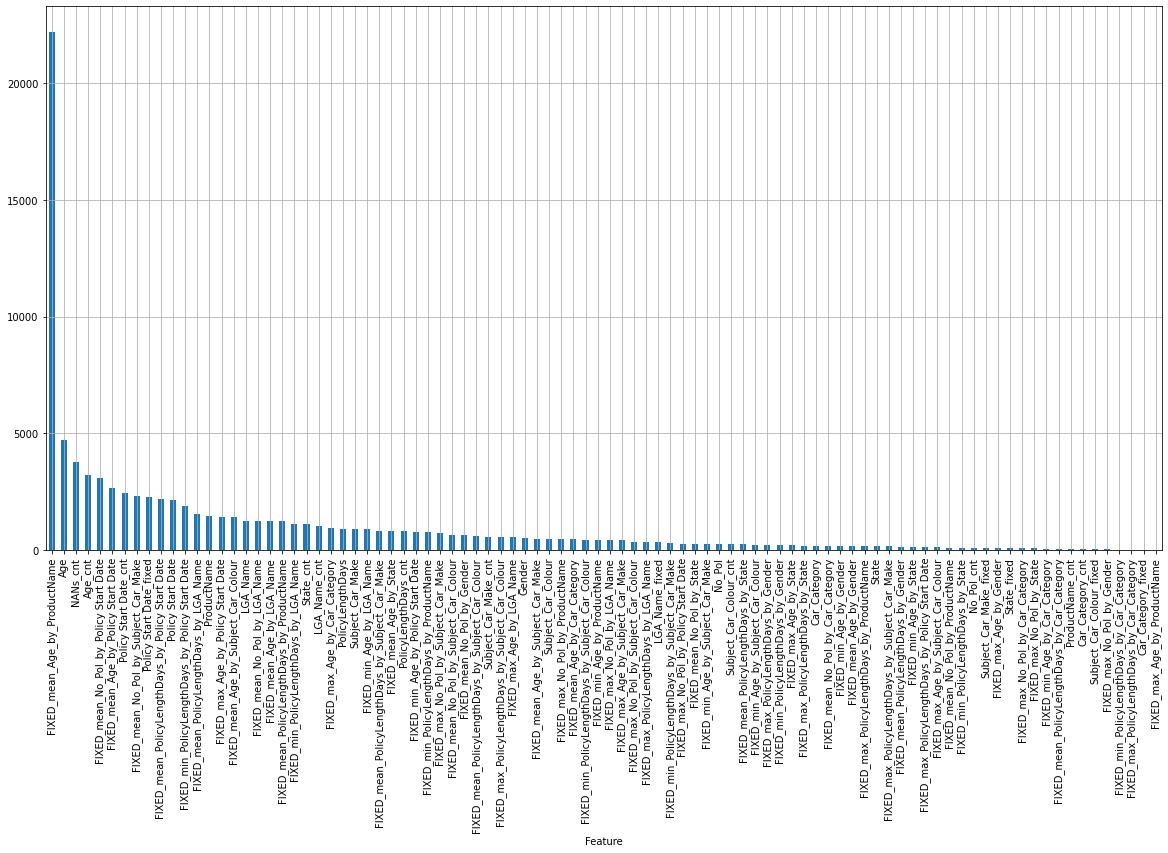

In [20]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [21]:
def f1_m(y_true, y_pred, bound = 0.5):
    return f1_score(y_true, (y_pred > bound).astype(int))

best_score = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    cur_score = f1_m(tr_data[TARGET_NAME].values, oof_pred.data[:, 0], w)
    if cur_score > best_score:
        best_score = cur_score
        best_w = w
        print(best_w, best_score)
        
print('='*10)
print(best_w, best_score)

0.0 0.21501801052923247
0.01 0.24948831196811375
0.02 0.3138006571741511
0.03 0.3379526151095217
0.04 0.35434956105347165
0.05 0.36943544260617434
0.06 0.38013196480938416
0.07 0.3926404384419652
0.08 0.40524235489910554
0.09 0.41934046345811055
0.1 0.42735849056603775
0.11 0.43244588206021395
0.12 0.4411764705882352
0.13 0.45257903494176377
0.15 0.46153846153846156
0.16 0.4655338249438923
0.17 0.4708249496981891
0.17 0.4708249496981891


## Step 4. Predict to test data and check scores

In [22]:
%%time

test_pred = automl.predict(te_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(f1_m(tr_data[TARGET_NAME].values, oof_pred.data[:, 0], best_w)))
print('TEST score: {}'.format(f1_m(te_data[TARGET_NAME].values, test_pred.data[:, 0], best_w)))

Prediction for test data:
array([[0.6560721 ],
       [0.00842952],
       [0.03108966],
       ...,
       [0.08877208],
       [0.03497621],
       [0.14498393]], dtype=float32)
Shape = (2416, 1)
Check scores...
OOF score: 0.4708249496981891
TEST score: 0.4109232769830949
CPU times: user 2.78 s, sys: 301 ms, total: 3.08 s
Wall time: 358 ms


## Step 5. Create AutoML with time utilization 

Below we are going to create specific AutoML preset for TIMEOUT utilization (try to spend it as much as possible):

In [23]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       configs_list = ['./selected_config.yml'],
                       verbose = 0
                      )
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.26326528],
       [0.01951091],
       [0.04869098],
       ...,
       [0.00659646],
       [0.01106302],
       [0.24481077]], dtype=float32)
Shape = (9663, 1)
CPU times: user 14h 19min 34s, sys: 33min 9s, total: 14h 52min 44s
Wall time: 53min 54s


CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 146 ms


<AxesSubplot:xlabel='Feature'>

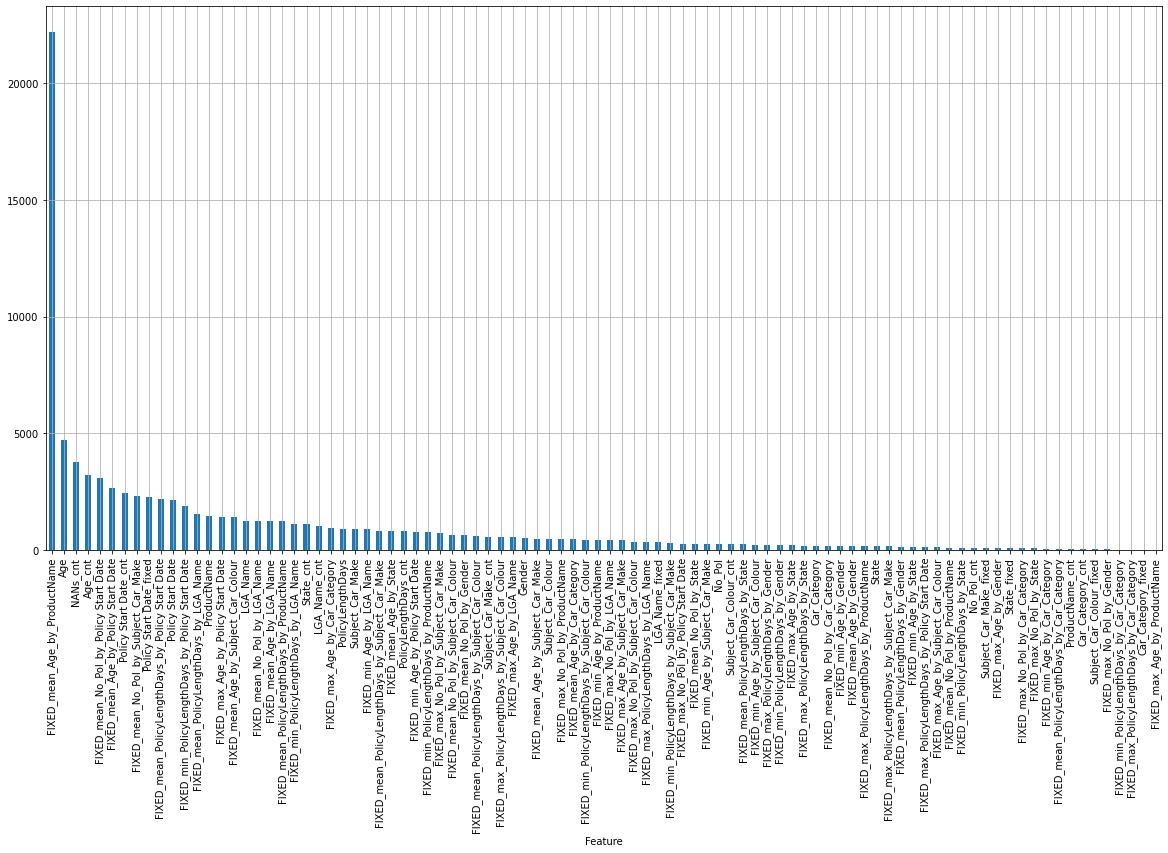

In [24]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [25]:
best_score = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    cur_score = f1_m(tr_data[TARGET_NAME].values, oof_pred.data[:, 0], w)
    if cur_score > best_score:
        best_score = cur_score
        best_w = w
        print(best_w, best_score)
        
print('='*10)
print(best_w, best_score)

0.0 0.21501801052923247
0.01 0.2793053545586107
0.02 0.3119640669661086
0.03 0.332217207744941
0.04 0.3461302211302211
0.05 0.3618985906366435
0.06 0.3766278272789582
0.07 0.3884267631103074
0.08 0.40315748941085866
0.09 0.4117527035298918
0.1 0.4275141488898564
0.11 0.43838150289017336
0.12 0.4470012239902081
0.13 0.4567295272539395
0.14 0.4631809471667124
0.15 0.4724227548368467
0.16 0.48085106382978726
0.18 0.4862876254180602
0.19 0.4890434782608696
0.2 0.49691693870148723
0.2 0.49691693870148723


## Step 6. Predict to test data and check scores for utilized automl

In [26]:
%%time

test_pred = automl.predict(te_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(f1_m(tr_data[TARGET_NAME].values, oof_pred.data[:, 0], best_w)))
print('TEST score: {}'.format(f1_m(te_data[TARGET_NAME].values, test_pred.data[:, 0], best_w)))

Prediction for test data:
array([[0.6922892 ],
       [0.00676856],
       [0.01916714],
       ...,
       [0.09803031],
       [0.03827016],
       [0.16256902]], dtype=float32)
Shape = (2416, 1)
Check scores...
OOF score: 0.49691693870148723
TEST score: 0.408695652173913
CPU times: user 8.05 s, sys: 788 ms, total: 8.84 s
Wall time: 1.3 s


## Step 7. Train on full dataset

In [27]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       configs_list = ['./selected_config.yml'],
                       verbose = 0
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.12401809],
       [0.04979165],
       [0.2615149 ],
       ...,
       [0.00229428],
       [0.24566281],
       [0.03772594]], dtype=float32)
Shape = (12079, 1)
CPU times: user 14h 24min 1s, sys: 32min 42s, total: 14h 56min 43s
Wall time: 54min 48s


In [28]:
best_score = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    cur_score = f1_m(train_data[TARGET_NAME].values, oof_pred.data[:, 0], w)
    if cur_score > best_score:
        best_score = cur_score
        best_w = w
        print(best_w, best_score)
        
print('='*10)
print(best_w, best_score)

0.0 0.2150140387173046
0.01 0.2996464961530464
0.02 0.3304889298892989
0.03 0.3466796875
0.04 0.3621823810138011
0.05 0.38075601374570445
0.06 0.39696217321454647
0.07 0.4143190661478599
0.08 0.42534979423868313
0.09 0.4391182645206439
0.1 0.4516485540615214
0.11 0.4644034917555772
0.12 0.4733292458614347
0.13 0.4805501826778424
0.14 0.49110961062345254
0.15 0.49727939436952917
0.16 0.5065675340768276
0.17 0.5122265122265123
0.18 0.5182403433476396
0.19 0.5191560244308717
0.19 0.5191560244308717


In [29]:
%%time

test_pred = automl.predict(test_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(f1_m(train_data[TARGET_NAME].values, oof_pred.data[:, 0], best_w)))

Prediction for test data:
array([[0.05511523],
       [0.05628668],
       [0.03076381],
       ...,
       [0.16402017],
       [0.04646881],
       [0.13595067]], dtype=float32)
Shape = (1202, 1)
Check scores...
OOF score: 0.5191560244308717
CPU times: user 5.18 s, sys: 125 ms, total: 5.31 s
Wall time: 1.07 s


## Step 8. Create submission file 

In [30]:
submission = test_data[['ID']]
submission[TARGET_NAME] = (test_pred.data[:, 0] > best_w).astype(int)
submission

,ID,target
12079,ID_01QM0NU,0
12080,ID_024NJLZ,0
12081,ID_02NOVWQ,0
12082,ID_02VSP68,0
12083,ID_02YB37K,0
...,...,...
13276,ID_ZTTHC5X,0
13277,ID_ZUJAFUP,0
13278,ID_ZWHCTUM,0
13279,ID_ZWQRL8L,0


In [31]:
submission.to_csv('lightautoml_f1_012_multirun.csv', index = False)